In [ ]:
import torch # torch is a folder, __init__.py in that torch folder imports other .py files in that torch folder, i can then import any of those imports with torch dot whatever
import torch.nn.functional as F

# uncomment for file download:
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda' and torch.cuda.is_bf16_supported():
    dtype = torch.bfloat16
elif device == 'cuda':
    dtype = torch.float16
else:
    dtype = torch.float32

print(f"Using: {device}, dtype: {dtype}")

# config
batch_size = 64
dim = 128 # embedding vector (aka token vector) length
n_layers = 2 # number of transformer blocks
mlp_dim = 256 # hidden layer 1 nodes in MLP
ctx_len = 32 # how many tokens it looks at, at once

# load data
with open("input.txt", "r") as f:
    text = f.read()

# char tokenizer
chars = sorted(set(text)) # set finds unique chars, sorted puts them in order
vocab_size = len(chars) # number of unique tokens in the vocabulary
stoi = {c:i for i,c in enumerate(chars)} # stoi is a dictionary. this loop (or dict comprehension) built it. from then on, stoi now is dict like {'a': 0, 'b': 1, ...}
itos = {i:c for c,i in stoi.items()} # itos is the reverse of stoi. itos is like {0: 'a', 1: 'b', ...}
encode = lambda s: [stoi[c] for c in s] # makes list, gets int (id) from stoi dictionary by single char as key, that char came from string. like s = abc, c = a first, then c = b, etc.
decode = lambda l: ''.join([itos[i] for i in l]) # reverse of encode, and makes list into string by using ''.join
print(f"Vocab size: {vocab_size}, dim: {dim}, layers: {n_layers}")

emb = torch.randn(vocab_size, dim, device=device, dtype=dtype) * 0.02 # creates emb matrix where each row represents 1 tokens embedding vector
pos = torch.randn(ctx_len, dim, device=device, dtype=dtype) * 0.02 # same as emb but for positional embeddings. each row represents 1 position in the context window, and the values in that row are the positional embedding elements for that position. pos[0] is the positional embedding for the first token in the context window, pos[1] is for the second token, etc.


# Transformer block weights


# 1st Block Weights
# -----------------------------------------------
# 1st attention
wq0 = torch.randn(dim, dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # weight matrix for q, input dim is rows and it's for dot producting with nx (RMS normalized x) row vector
wk0 = torch.randn(dim, dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # weight matrix for k, same as q
wv0 = torch.randn(dim, dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # weight matrix for v, same as q and k

# 1st MLP
w10 = torch.randn(dim, mlp_dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # weight matrix for MLP input to hidden layer
w20 = torch.randn(mlp_dim, dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # weight matrix for MLP hidden layer to output
# -----------------------------------------------



# 2nd Block Weights
# -----------------------------------------------
# 2nd Attention
wq1 = torch.randn(dim, dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # takes in the output from 1st block
wk1 = torch.randn(dim, dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # same as wq1
wv1 = torch.randn(dim, dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # same as wq1 and wk1

# 2nd MLP
w11 = torch.randn(dim, mlp_dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # weight matrix for MLP in 2nd, input to hidden layer
w21 = torch.randn(mlp_dim, dim, device=device, dtype=dtype) * (0.1 / (2 ** 0.5)) # weight matrix for MLP in 2nd, hidden layer to output
# -----------------------------------------------




params = [emb, pos, wq0, wk0, wv0, w10, w20, wq1, wk1, wv1, w11, w21]
for p in params:
    p.requires_grad = True

def rmsnorm(x, eps=1e-5):
    return x / ((x ** 2).mean(dim=-1, keepdim=True).sqrt() + eps)

def forward(x):
    B, T = x.shape # x.shape(batch_size, ctx_len-1) B = batch size, T = sequence length (context length - 1). Because x = all_seqs[idx, :-1] — the last token is sliced off to become the target y
    x = emb[x] + pos[:T] # C = dim, emb[x].shape(B,T,C), pos[:T].shape(T,C), + broadcasts pos[:T] along dimension 0 for element wise add, pos[:T] indexing is up to but not including T value (slicing rules)



    # Transformer Blocks

    # ------------------------------------------------
    # 1st Block

    # Norm
    nx = rmsnorm(x)

    # Attention
    # Formula for attention scores: (Q @ K^T) / sqrt(d_k), where Q is the query matrix, K is the key matrix, and d_k is the dimension of the key vectors. This formula computes the attention scores by taking the dot product of the query and key matrices, and then scaling it by the square root of the dimension of the key vectors to prevent large values that can lead to exploding softmax
    q, k, v = nx @ wq0, nx @ wk0, nx @ wv0
    scores = q @ k.transpose(-2, -1) / (q.size(-1) ** 0.5) # actual attention calculations
    mask = torch.tril(torch.ones(T, T, device=device, dtype=torch.bool)) # creates matrix filled with 1s in the lower triangle and diagonal, and 0s in the upper triangle.
    scores = scores.masked_fill(~mask, float('-inf')) # ~ is bitwise not. Here it flips the mask so that the lower triangle and diagonal are False, and the upper triangle is True. Then masked_fill replaces the True values (upper triangle) with -inf, which effectively masks out those positions in the attention scores. Then it leaves everything else alone
    sm = F.softmax(scores, dim=-1) # probabilities per row
    attn_out = sm @ v # shape (B, T, C) because sm is (B, T, T) and v is (B, T, C). This is the output of the attention mechanism
    x = x + attn_out # residual connection, adds attn input to attn output, shape (B, T, 128)

    # Norm
    nx = rmsnorm(x)

    # MLP
    out = nx @ w10 # shape (B, T, 256)
    out = out.relu() # shape (B, T, 256), applies ReLU activation function element-wise
    out = out @ w20 # shape (B, T, 128), this is the output of the MLP
    x = x + out # residual connection, adds mlp input to mlp output, shape (B, T, 128)
    # -------------------------------------------------


    # -------------------------------------------------


    # -------------------------------------------------
    # 2nd Block

    # Norm
    nx = rmsnorm(x) # x is input from 1st block, shape (B, T, 128)

    # Attention
    q, k, v = nx @ wq1, nx @ wk1, nx @ wv1
    scores = q @ k.transpose(-2, -1) / (q.size(-1) ** 0.5)
    mask = torch.tril(torch.ones(T, T, device=device, dtype=torch.bool))
    scores = scores.masked_fill(~mask, float('-inf'))
    sm = F.softmax(scores, dim=-1)
    attn_out = sm @ v
    x = x + attn_out

    # Norm
    nx = rmsnorm(x)

    # MLP
    out = nx @ w11
    out = out.relu()
    out = out @ w21
    x = x + out
    # -------------------------------------------------


    # print(f'{x.shape=}', f'{emb.T.shape=}') # x is (B, T, 128) and emb.T is (128, vocab_size)
    x = x @ emb.T # x is prediction vector, that vector dots with emb.T to get similarity scores (dot product), which is most similar can be next token prediction. shape (B, T, vocab_size) because x is (B, T, 128) and emb.T is (128, vocab_size)
    return x
    
    '''
    one x row mul and add with each emb row, to get similarity score for each token. The highest score is the predicted next token. The blocks learn to push x toward the embedding of the correct next token, so that the dot product (similarity) is highest for the correct next token.
    Say dim=3, vocab=3 for simplicity:

    emb = [[0.2, 0.5, 0.1],   # token "a"
        [0.9, 0.1, 0.3],   # token "b"  
        [0.1, 0.8, 0.2]]   # token "c"
    Output vector after all blocks: x = [0.85, 0.15, 0.28]

    x @ emb.T = dot product of x with each row:

    vs "a": 0.85*0.2 + 0.15*0.5 + 0.28*0.1 = 0.27
    vs "b": 0.85*0.9 + 0.15*0.1 + 0.28*0.3 = 0.86 ← highest
    vs "c": 0.85*0.1 + 0.15*0.8 + 0.28*0.2 = 0.26
    Result: [0.27, 0.86, 0.26] → model predicts "b" because x is most similar to "b"'s embedding.

    The blocks learned to push x toward the embedding of the correct next token.
    '''


if hasattr(torch, 'compile'):
    forward = torch.compile(forward) # compiles forward, removes python interpretor, looks at all the ops, makes less trips between vram and gpu cores with kernel fusion where instead of doing a calculation for 1 var by carrying data from vram to gpu cores doing an intermediate calculation then bringing  result back to vram then taking that answer back to cores for next operation then returning to vram over and over it fuses (combines) all those operations into 1 transfer then does the calculations then returns result to vram
    print("Using torch.compile")

tokens = torch.tensor(encode(text), device=device) # encoding text to list of numbers (token ids), converting that list to a tensor
'''
all_seqs = [] # stores tensors in this list. shape eg. (1000000, 32) aka (all tokens in file, context len) stores like lists of all context size sequences in the fiile. So if ctx_len is 32, it stores all sequences of 32 tokens (sliding 1 token at a time) in the file, which are the training examples. Each sequence is a sequence of token ids (integers).
for i in range(len(tokens) - ctx_len + 1): # same pattern as convolutional kernal... len of total elements minus window (or convolutional kernel) size + 1.
    all_seqs.append(tokens[i : i + ctx_len]) # ctx len is how wide is that window or kernel. i changes by step size. makes list of tokens 0 to 31, appends all those to all_seq list, next iter looks at tokens 1 to 32, appends that list as next row of tokens, etc.
all_seqs = torch.stack(all_seqs) # converts list of seperate tensors to one matrix tensor
'''
all_seqs = tokens.unfold(dimension=0, size=ctx_len, step=1) # same as torch.stack, just faster. shape (kind of like cnn number of chars in whole file like 1115390 minus window size like 32 and + 1 for the starting window position, ctx_len)

# train
opt = torch.optim.Adam(params, lr=1e-4, fused=True) # creates object instance of Adam. optimizer = update like w -= lr * grad, except adam does other details too. fused kernal aka looks at all calculations and carries data for processing all before returning results to vram instead of doing one op then returning result then doing next op combined with previous result carried back from vram so basically less trips.
'''
Adam = Adaptive + Momentum combined. Momentum is like a running average of the gradients, so it helps to smooth out the updates and can help to accelerate convergence in the relevant direction and dampen oscillations. The momentum term is calculated as m = b_1 * m + (1 - b_1) * grad, where m is the momentum, b_1 is the momentum decay factor (usually around 0.9), and grad is the current gradient. The adaptive part (Ada) adjusts the learning rate for each parameter based on the historical gradients, which helps to improve convergence.
eg. of momentum with how much of old momentum to keep = b_1 = beta sub 1 = 0.9...
# Adam formula, for updating parameter:
param -= lr * m / (√v + ε)


m = b_1 * m + (1 - b_1) * grad
v = b_2 * v + (1 - b_2) * (grad ** 2)
grad sequence: [4, 2, 6, 1]

Step 1: m = 0.9(0)   + 0.1(4) = 0.4
Step 2: m = 0.9(0.4) + 0.1(2) = 0.56
Step 3: m = 0.9(0.56)+ 0.1(6) = 1.104
Step 4: m = 0.9(1.104)+0.1(1) = 1.094



m = momentum (direction to go)
√v = adapts step size (Ada part)
ε = tiny number to avoid division by zero (~1e-8)
lr = learning rate
Adam = Adaptive + Momentum combined.
'''


for i in range(10000): # number of training iterations, each iteration is one batch of training examples
    idx = torch.randint(0, all_seqs.shape[0], (batch_size,)) # random rows of context to process. also, part of the benifit of looking at parts of instead of the whole file is kind of like cnn translation invariance where it can learn patterns regardless of where they are in the context window, like learning cat ear shape no matter it is in an image. shape (batch_size,) because it's a list of row indices to select for the batch
    x = all_seqs[idx, :-1] # shape (batch_size, ctx_len-1) grabs random row, all elements in that row except the last, to predict all row elements in y (y is same indeices in x but shifted by + 1)
    y = all_seqs[idx, 1:] # grabs same row as x, grabs same elements as x but shifted by + 1, so each element becomes what the transformer should predict, aka next token prediction. each y element is the correct next token.

    logits = forward(x) # raw results from the transformer. makes tensors same shape, ignores dim 0, does regular matmul, then puts dim 0 in resulting tensor. shape (batch_size, ctx_len-1, vocab_size) because forward returns x @ emb.T and x is (B, T, 128) and emb.T is (128, vocab_size)
    # print(f'{logits.shape=}')
    loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1)) # logits becomes shape rows = every prediction in batch and every context len prediction in that batch, columns are each vocab letter, y indexes into the target index of each prediction. then each of those goes into negative natural log, then all the outputs are averaged, that is the loss.

    opt.zero_grad() # makes all grads 0 so they don't add (or accumulate) to previous batch of grads
    loss.backward() # computes gradients (partial derivatives of loss w.r.t. each parameter) via backpropagation, stores them in each tensor's .grad
    opt.step() #updates weights with grads from loss.backward()

    if i % 100 == 0: # every 100 iterations print loss
        print(f"{i}: loss={loss.item():.2f}") # loss.item() gets the scalar value of the loss tensor for printing, and formats it to 2 decimal places

In [3]:
# generate
ctx = "First Citizen"
tokens = encode(ctx)
print(tokens)

for _ in range(500):
    x = torch.tensor([tokens[-(ctx_len-1):]], device=device)
    logits = forward(x)
    probs = F.softmax(logits[0, -1] / 0.8, dim=-1)
    next_token = torch.multinomial(probs, 1).item()
    tokens.append(next_token)

print(decode(tokens))

NameError: name 'encode' is not defined

In [5]:
all_seqs.shape, tokens.shape, len(text)

(torch.Size([1115359, 32]), torch.Size([1115390]), 1115390)

In [6]:
x.shape

torch.Size([64, 31])

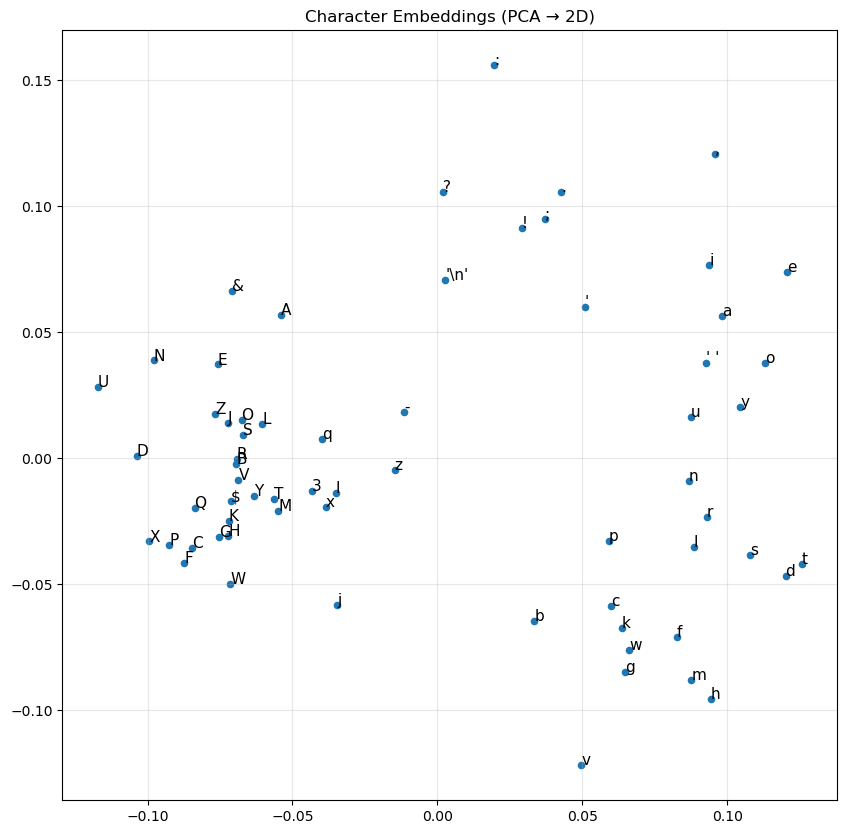

In [3]:
import matplotlib.pyplot as plt

# PCA: project 128-dim embeddings → 2D
E = emb.detach().float().cpu() # (vocab_size, 128)
E = E - E.mean(dim=0) # center
U, S, V = torch.svd(E) # SVD on centered data = PCA
coords = E @ V[:, :2] # project onto top 2 principal components, shape (vocab_size, 2)

plt.figure(figsize=(10, 10))
plt.scatter(coords[:, 0].numpy(), coords[:, 1].numpy(), s=20)
for i, c in itos.items():
    label = repr(c) if c in (' ', '\n', '\t') else c
    plt.annotate(label, (coords[i, 0].item(), coords[i, 1].item()), fontsize=11)
plt.title("Character Embeddings (PCA → 2D)")
plt.grid(True, alpha=0.3)
plt.show()